In [1]:
%load_ext autoreload

import os, sys
sys.path.insert(0, '../')

In [2]:
%autoreload
from extract_utils.querier import *
from extract_utils.display_utils import *

import itertools, os, psycopg2, re, sys, time, numpy as np, pandas as pd
from sklearn import metrics
from datetime import datetime
from datetime import timedelta
from collections import Counter, defaultdict

from os.path import isfile, isdir, splitext
import argparse
import pickle as cPickle
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

SQL_DIR = os.path.join('./SQL_Queries')
STATICS_QUERY_PATH = os.path.join(SQL_DIR, 'statics.sql')
LABS_QUERY_PATH = os.path.join(SQL_DIR, 'labs.sql')
VITALS_QUERY_PATH = os.path.join(SQL_DIR, 'vitals.sql')
TREATMENTS_QUERY_PATH = os.path.join(SQL_DIR, 'treatments.sql')
CODES_QUERY_PATH = os.path.join(SQL_DIR, 'codes.sql')

In [3]:
BLINDED = True

# Questions on eICU
  1. In `lab`, `labresultoffset` vs. `labresultrevisedoffset`?

### Set up Args

In [5]:
idx_slice = pd.IndexSlice

In [24]:
args = {
    # Querier Params
    'psql_host': '/var/run/postgresql/',
    
    # Pop Restrictions
    'pop_size': 3000000,
    'min_age': 15,
    'min_duration': 24,
    'max_duration': 240,
    'min_labs_thresh': 5,
    'min_institution_patients': 500,
    
    # Output directory
    'out_path': '/crimea/latent_patient_trajectories/processed_data/eicu_extract.hdf'
}

### Set up Querier

In [6]:
dbname = 'eicu'
schema_name = 'public'
query_args = {'dbname': dbname}
if args['psql_host'] is not None: query_args['host'] = args['psql_host']
# if args['psql_user'] is not None: query_args['user'] = args['psql_user']
# if args['psql_password'] is not None: query_args['password'] = args['psql_password']

querier = Querier(query_args=query_args, schema_name=schema_name)

### Helper Functions

In [7]:
def range_unnest(df, col, out_col_name=None, reset_index=False):
    assert len(df.index.names) == 1, "Does not support multi-index."
    if out_col_name is None: out_col_name = col

    col_flat = pd.DataFrame(
        [[i, x] for i, y in df[col].iteritems() for x in range(y+1)],
        columns=[df.index.names[0], out_col_name]
    )

    if not reset_index: col_flat = col_flat.set_index(df.index.names[0])
    return col_flat

### Extract Cohort

In [8]:
#############
# Population extraction

start = time.time()

print("Building data from scratch.")
pop_size_string = f"LIMIT {args['pop_size']}" if args['pop_size'] > 0 else ""

min_age_string = str(args['min_age'])
min_dur_string = str(args['min_duration'])
max_dur_string = str(args['max_duration'])
min_day_string = str(float(args['min_duration'])/24)

template_vars = dict(
    limit=pop_size_string, min_age=min_age_string, min_dur=min_dur_string, max_dur=max_dur_string,
    min_day=min_day_string
)

data_df = querier.query(
    query_file=STATICS_QUERY_PATH, extra_template_vars=template_vars
)
raw_data_df = data_df.copy()

end = time.time()
print(f"Took {(end - start)/60} minutes")

Building data from scratch.
Took 0.022643681367238364 minutes


In [10]:
blind_display(data_df, blinded=BLINDED)

data_df.shape:  (103874, 22)


,subject_id,hadm_id,icustay_id,hospital_id,region,icustay_seq,gender,age,ethnicity,los_icu,...,intime,outtime,max_hours_unit,max_hours_hospital,deathtime,discharge_location,mort_hosp,mort_icu,hospital_discharge_year,unit_type


In [18]:
patients_per_hospital = defaultdict(set)
for _, (h, s) in data_df[['hospital_id', 'subject_id']].iterrows():
    patients_per_hospital[h].update([s])

In [25]:
valid_stays = set(
    h for h, s in patients_per_hospital.items() \
    if len(s) > args['min_institution_patients']
)

In [26]:
frac = len(valid_stays)/len(patients_per_hospital)
n_stays = len(data_df[data_df.hospital_id.isin(valid_stays)])
frac_stays = n_stays / len(data_df)
print(
    f"{len(valid_stays)} of {len(patients_per_hospital)} ({100*frac:.2f}%) hospitals "
    f"are valid. This accounts for {n_stays} of {len(data_df)} "
    f"({frac_stays*100:.2f}%) total stays."
)

59 of 208 (28.37%) hospitals are valid. This accounts for 72986 of 103874 (70.26%) total stays.


In [27]:
data_df = data_df[data_df.hospital_id.isin(valid_stays)]

In [28]:
raw_data_icustays = set(data_df.icustay_id)

### Add exclusion criteria for remaining queries

In [29]:
querier.add_exclusion_criteria_from_df(data_df, columns=['hadm_id', 'subject_id', 'icustay_id'])

### Extract Labs

In [30]:
##
# Unit Conversion Explanations
# 1 meq/ml  * (1 = 1000 ml / 1L) = # me1 / L
# 1 mg/dl   * (1 = 1 (mmol/l) / 4.0078 (mg/dl)) = # mmol/l CALCIUM ONLY

UNIT_CONVERSIONS = {
    ('potassium', 'sodium', 'chloride'): (
        'mmol/l', {('meq/l', 'mmoll'): 1, ('meq/ml',): 1000}
    ),
    'Hgb':              ('g/dl', {('gm/dl',): 1}),
    'Hct':              ('%', {('%pcv',): 1}),
    'calcium':          ('mmol/l', {('mg/dl',): 1/4.0078}),
    'bicarbonate':      ('mmol/l', {('meq/l', 'mmole/l', 'meq/ml', 'mmoll'): 1}),
    'platelets x 1000': ('k/ul', {
        ('k/mcl', 'k/ul', 'k/mm3', 'k/cmm', 'th/ul', 'k/mmcu', 'th/mm3', '10e3/mcl',
         'th/cmm', '10(3)/mcl', 'thou/cumm', 'x103/ul', '10*3/ul', '/nl', '10(3)mcl',
         'x10e3/ul', 'ths/ul', '10', 'x10^3/ul', 'x(10)3/ul', '10x3', 'x10"3',
         'x10(3)', 'thou/cmm', 'thou/ul', '*10^3/ul', 'bil/l', '1000/cmm', '10e3/ul',
         'x1000', 'x10*3', 'thousand', '10x3/ul', '10*9/l', 'k/cumm', 'x10(3)/mcl',
         'th/cumm', 'x10-3', 'x103', '10e3', 'thd/ul', 'thou/mm3', 'thous/ul', '10*3',
         '103/ul'): 1,
    }),
    'WBC x 1000':       ('k/ul', {
        ('k/mcl', 'k/ul', 'k/mm3', 'k/cmm', 'th/mm3', 'k/mmcu', 'th/ul', '10(3)/mcl',
         '10e3/mcl', 'th/cmm', 'thou/cumm', 'x103/ul', '10*3/ul', '/nl', 'ths/ul',
         '10', 'x(10)3/ul', 'x10^3/ul', '10x3/mm', 'x10"3', 'x10(3)', 'thou/cmm',
         'thou/ul', '*10^3/ul', '1000/cmm', '10e3/ul', 'x1000', 'x10*3', '10*9/l',
         '10x3/ul', 'k/cumm', 'x10e3/ul', 'th/cumm', 'x10(3)/mcl', 'x10-3', 'x103',
         '10e3', '103/ul', 'thou/mm3', 'thous/ul', '10*3'): 1,
    }),
    'RBC':              ('m/ul', {
        ('m/ul', 'mil/ul', 'm/mm3', 'mil/mcl', 'mil/mm3', '10(6)/cl', '10e6/mcl',
         'mill/ul', 'x106/ul', '10*6/ul', 'x(10)6/ul', 'x10^6/ul', '*10^6/ul',
         '10x6/mm', 'x10"6', 'x10(6)', '*10^6/ul', '10e6/ul', 'x1000000', 'x10*6',
         '10x6/ul', 'x10e6/ul', 'x10(6)/mcl', 'x10-6', 'x106', '10e6', '106/ul',
         '10*6', 'mill/mm3', 'm/cmm', 'm/mmcu', 'mill/cumm', 'mil/cmm', 'mill/cmm',
         'mi/cumm'): 1,
    }),
    'MCV':              ('fl', {('u3',): 1}),
    'MCHC':             ('g/dl', {('%', 'gm/dl', 'g/dlrbc'): 1}), 
#     'RDW':              ()
#     'MCH':              ()
    'anion gap':        ('mmol/l', {('meq/l', 'mmoll'): 1}),
}

expanded_unit_conversion = {}
for k, v in UNIT_CONVERSIONS.items():
    if type(k) is str: expanded_unit_conversion[k] = v
    else:
        for e in k: expanded_unit_conversion[e] = v

def unify_units(x):
    if not x['valueuom_system']: return x['valueuom_interface']
    elif not x['valueuom_interface']: return x['valueuom_system']
    elif x['valueuom_interface'] == x['valueuom_system']: return x['valueuom_system']
    elif x['itemid'] in expanded_unit_conversion:
        out_unit, raw_unit_conv = expanded_unit_conversion[x['itemid']]
        ks = list(raw_unit_conv.keys())
        unit_equivalency_groups = [[out_unit]] + ks
        unit_conv_factors = [1] + [raw_unit_conv[k] for k in ks]
        
        idx_system, idx_interface = None, None
        for i, g in enumerate(unit_equivalency_groups):
            if x['valueuom_interface'] in g: idx_interface = i
            if x['valueuom_system'] in g: idx_system = i
        
        return x['valueuom_system'] if idx_system == idx_interface else ''
    else: return ''

In [31]:
start = time.time()
labs_df = querier.query(query_file=LABS_QUERY_PATH)
raw_labs_df = labs_df.copy()

for col in ['valueuom_system', 'valueuom_interface']:
    labs_df[col] = labs_df[col].str.lower().str.replace(" ", "")

labs_df['valueuom_unified'] = labs_df[
    ['itemid', 'valueuom_system', 'valueuom_interface']
].apply(
    unify_units, axis=1
)

for itemid, (out_unit, unit_conv_dict) in expanded_unit_conversion.items():
    already_done_idx = None
    for conv_list, conv_factor in unit_conv_dict.items():
        idx = (labs_df.itemid == itemid) & labs_df.valueuom_unified.isin(conv_list)
        labs_df.loc[idx, 'value'] = labs_df.loc[idx, 'value'] * conv_factor
        labs_df.loc[idx, 'unified_unit'] = out_unit
        
        if already_done_idx is None: already_done_idx = idx
        else: 
            double_converted = (idx & already_done_idx).sum()
            if double_converted > 0: print(
                f"Double converted {double_converted} on {itemid}, {out_unit}"
            )
            already_done_idx = already_done_idx | idx
            
counter_uoms_by_itemid = labs_df.groupby(by='itemid')[
    ['valueuom_system', 'valueuom_interface', 'valueuom_unified']
].agg(lambda x: Counter(e.replace(' ', '') for e in x.str.lower() if e))
counter_uoms_by_itemid['valueuom_overall'] = counter_uoms_by_itemid.apply(
    lambda x: Counter(x['valueuom_system']) + Counter(x['valueuom_interface']), axis=1
)

labs_df.drop(columns=['valueuom_system', 'valueuom_interface'], inplace=True)
valid_idx = None
for itemid, uom_ctr in counter_uoms_by_itemid['valueuom_unified'].iteritems():
    if not uom_ctr: continue
    most_common_uom, cnt = uom_ctr.most_common(1)[0]
    total = sum(uom_ctr.values())
    print(f"Restricting {itemid} to just {most_common_uom} ({100*cnt/total:.2f}%)")
    idx = (labs_df.itemid == itemid) & (labs_df.valueuom_unified == most_common_uom)
    if valid_idx is None: valid_idx = idx
    else: valid_idx |= idx
        
pre_shape = labs_df.shape
labs_df = labs_df.loc[valid_idx]
post_shape = labs_df.shape
print(f"Dropping invalid units. Pre-shape: {pre_shape}, Post-shape: {post_shape}")

labs_df.value = pd.to_numeric(labs_df.value, 'coerce')

blind_display(labs_df, blinded=BLINDED)

labs_df.drop(inplace=True, columns=['valueuom_unified'])
labs_df = labs_df.groupby(
    ['subject_id', 'hadm_id', 'icustay_id', 'itemid', 'hours_in']
).agg(['mean', 'std', 'count'])

labs_df.columns = labs_df.columns.droplevel(0)
labs_df.columns.names = ['Aggregation Function']

missing_hours_fill = range_unnest(
    data_df.set_index('icustay_id'), 'max_hours_unit', out_col_name='hours_in',
    reset_index=True
)
missing_hours_fill['tmp'] = np.NaN

fill_df = data_df[['icustay_id', 'hadm_id', 'subject_id']].join(
    missing_hours_fill.set_index('icustay_id'), on='icustay_id'
)
N = fill_df.shape[0]

count_per_itemid = labs_df.groupby('itemid')['mean'].count()
measurement_freq_per_itemid = count_per_itemid / N

valid_itemids = measurement_freq_per_itemid[
    measurement_freq_per_itemid > (args['min_labs_thresh']/100)
]

labs_df_pre_unstack = labs_df.copy()
labs_df = labs_df[labs_df.index.get_level_values('itemid').isin(valid_itemids.index)]

labs_df = labs_df.unstack(level=['itemid'])
labs_df_post_unstack = labs_df.copy()

fill_df.set_index(labs_df.index.names, inplace=True)

labs_df.columns = labs_df.columns.reorder_levels(
    order=['itemid', 'Aggregation Function']
)
labs_df = labs_df.reindex(fill_df.index)
labs_df_post_reindex = labs_df.copy()

labs_df = labs_df.sort_index(axis=0).sort_index(axis=1)
labs_df_post_sort = labs_df.copy()

lab_counts = labs_df.loc[:, idx_slice[:, 'mean']].count(axis=0)
lab_counts.index = lab_counts.index.get_level_values('itemid')
lab_counts = lab_counts.sort_values(ascending=False)

end = time.time()
print(f"Took {(end - start)/60} minutes")

Restricting -bands to just % (100.00%)
Restricting -basos to just % (100.00%)
Restricting -eos to just % (100.00%)
Restricting -lymphs to just % (100.00%)
Restricting -monos to just % (100.00%)
Restricting -polys to just % (100.00%)
Restricting 24 h urine protein to just mg/24hr (100.00%)
Restricting 24 h urine urea nitrogen to just g/24hr (100.00%)
Restricting ALT (SGPT) to just units/l (100.00%)
Restricting ANF/ANA to just eu (72.58%)
Restricting AST (SGOT) to just units/l (100.00%)
Restricting Acetaminophen to just mcg/ml (100.00%)
Restricting Amikacin - peak to just mcg/ml (100.00%)
Restricting Amikacin - random to just mcg/ml (100.00%)
Restricting Amikacin - trough to just mcg/ml (100.00%)
Restricting BNP to just pg/ml (100.00%)
Restricting BUN to just mg/dl (100.00%)
Restricting Base Deficit to just meq/l (100.00%)
Restricting Base Excess to just meq/l (100.00%)
Restricting CPK to just units/l (100.00%)
Restricting CPK-MB to just ng/ml (100.00%)
Restricting CPK-MB INDEX to just %

,subject_id,hadm_id,icustay_id,hours_in,itemid,value,valueuom_unified,unified_unit


Took 8.77838789621989 minutes


In [32]:
blind_display(labs_df, blinded=BLINDED)

labs_df.shape:  (5149200, 18)


Empty DataFrame
Columns: [(BUN, count), (BUN, mean), (BUN, std), (Hct, count), (Hct, mean), (Hct, std), (bedside glucose, count), (bedside glucose, mean), (bedside glucose, std), (creatinine, count), (creatinine, mean), (creatinine, std), (glucose, count), (glucose, mean), (glucose, std), (potassium, count), (potassium, mean), (potassium, std)]
Index: []

In [33]:
labs_icustay_ids = set(labs_df.index.get_level_values('icustay_id'))

In [34]:
assert labs_icustay_ids.issubset(raw_data_icustays)

### Extract Vitals

In [35]:
start = time.time()

vitals_df = querier.query(query_file=VITALS_QUERY_PATH)
vitals_df_raw = vitals_df.copy()
blind_display(vitals_df, blinded=BLINDED)

vitals_df.set_index(labs_df.index.names, inplace=True)
for col in vitals_df:
    vitals_df[col] = pd.to_numeric(vitals_df[col], 'coerce')
vitals_df = vitals_df.groupby(vitals_df.index.names).agg(['count', 'mean', 'std'])
    
count_per_vital = vitals_df.loc[:, idx_slice[:, 'mean']].count(axis=0)
measurement_freq_per_vital = count_per_vital / N

invalid_vitals = [x[0] for x in measurement_freq_per_vital[
    measurement_freq_per_vital <= (args['min_labs_thresh']/100)
].index]
vitals_df.drop(columns=[
    (k, a) for k, a in itertools.product(invalid_vitals, ('count', 'mean', 'std'))
], inplace=True)
vitals_df.loc[:, idx_slice[:, 'count']] = vitals_df.loc[
    :, idx_slice[:, 'count']
].fillna(0)
    
vitals_df.columns.names = labs_df.columns.names

labs_and_vitals_df = labs_df.join(vitals_df, how='outer')

end = time.time()
print(f"Took {(end - start) / 60} minutes")

vitals_df.shape:  (10204581, 30)


,subject_id,hadm_id,icustay_id,hours_in,temperature,sao2,heart_rate,respiratory_rate,cvp,etco2,...,noninvasive_systolic,noninvasive_diastolic,noninvasive_mean,paop,cardiac_output,cardiac_input,svr,svri,pvr,pvri


Took 5.478978840510051 minutes


In [36]:
vitals_df_icustay_id = set(vitals_df.index.get_level_values('icustay_id'))
assert vitals_df_icustay_id.issubset(raw_data_icustays)
labs_and_vitals_df_icustay_id = set(
    labs_and_vitals_df.index.get_level_values('icustay_id')
)
assert labs_and_vitals_df_icustay_id.issubset(raw_data_icustays)

In [37]:
blind_display(labs_and_vitals_df, blinded=BLINDED)

labs_and_vitals_df.shape:  (5149200, 45)


Empty DataFrame
Columns: [(BUN, count), (BUN, mean), (BUN, std), (Hct, count), (Hct, mean), (Hct, std), (bedside glucose, count), (bedside glucose, mean), (bedside glucose, std), (creatinine, count), (creatinine, mean), (creatinine, std), (glucose, count), (glucose, mean), (glucose, std), (potassium, count), (potassium, mean), (potassium, std), (sao2, count), (sao2, mean), (sao2, std), (heart_rate, count), (heart_rate, mean), (heart_rate, std), (respiratory_rate, count), (respiratory_rate, mean), (respiratory_rate, std), (st1, count), (st1, mean), (st1, std), (st2, count), (st2, mean), (st2, std), (st3, count), (st3, mean), (st3, std), (noninvasive_systolic, count), (noninvasive_systolic, mean), (noninvasive_systolic, std), (noninvasive_diastolic, count), (noninvasive_diastolic, mean), (noninvasive_diastolic, std), (noninvasive_mean, count), (noninvasive_mean, mean), (noninvasive_mean, std)]
Index: []

[0 rows x 45 columns]

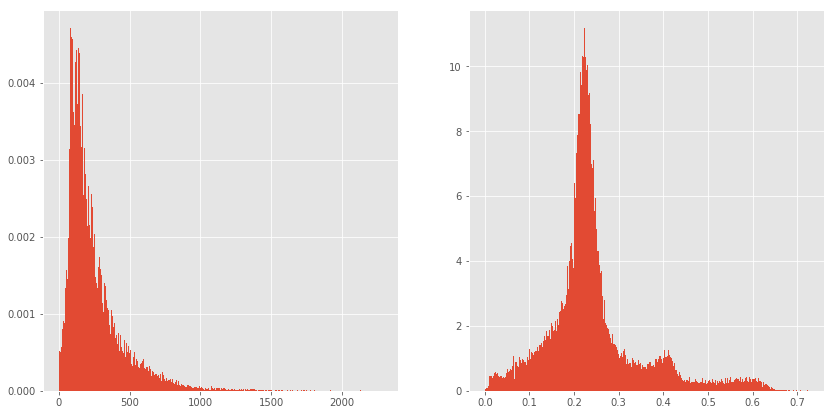

In [38]:
data_df.set_index(
    [c for c in labs_and_vitals_df.index.names if c != 'hours_in'], inplace=True
)
numerics_per_stay = labs_and_vitals_df.loc[:,idx_slice[:,'mean']].groupby(
    data_df.index.names
).count().sum(axis=1)
meas_rate_per_stay = numerics_per_stay / ((labs_and_vitals_df.shape[1]/3) * data_df['max_hours_unit'])

fig, (ax_cnt, ax_rate) = plt.subplots(nrows=1, ncols=2, sharey=False, figsize = (14, 7))
ax_cnt.hist(numerics_per_stay, bins=500, density=True)
ax_rate.hist(meas_rate_per_stay, bins=500, density=True)
None

In [39]:
raw_data_df.set_index(
    [c for c in labs_and_vitals_df.index.names if c != 'hours_in'], inplace=True
)

In [41]:
valid_stays = numerics_per_stay[numerics_per_stay > 10]
n_valid_stays, n_stays = len(valid_stays), len(numerics_per_stay)
print(f"{n_valid_stays} / {n_stays} ({100*n_valid_stays/n_stays:.2f}%) of stays are valid")
data_df = data_df.loc[data_df.index.get_level_values('icustay_id').isin(valid_stays.index.get_level_values('icustay_id'))].copy()
valid_icustays = set(data_df.index.get_level_values('icustay_id'))
labs_and_vitals_df = labs_and_vitals_df.loc[
    labs_and_vitals_df.index.get_level_values('icustay_id').isin(valid_icustays)
]
labs_df = labs_df.loc[
    labs_df.index.get_level_values('icustay_id').isin(valid_icustays)
]

72669 / 72986 (99.57%) of stays are valid


In [42]:
filt_data_icustays = set(data_df.index.get_level_values('icustay_id'))

In [43]:
filt_labs_and_vitals_df_icustay_id = set(
    labs_and_vitals_df.index.get_level_values('icustay_id')
)
assert filt_labs_and_vitals_df_icustay_id.issubset(filt_data_icustays)

In [44]:
querier.add_exclusion_criteria_from_df(data_df, columns=['hadm_id', 'subject_id', 'icustay_id'])

### Extract Treatments

In [45]:
def merge_treatment_lists(lists):
    out_list = [set([]) for _ in range(max(len(l) for l in lists.values))]
    for l in lists:
        for i, e in enumerate(l): out_list[i].update([e])
    return out_list

In [46]:
start = time.time()

treatments_df = querier.query(query_file=TREATMENTS_QUERY_PATH)
treatments_df.set_index(labs_and_vitals_df.index.names, inplace=True)
treatments_df['treatment_list'] = treatments_df.treatment_string.str.split('|')
treatments_df = treatments_df.groupby(
    treatments_df.index.names
)[['treatment_list']].agg(merge_treatment_lists)

treatments_df['treatment_area'] = treatments_df['treatment_list'].apply(
    lambda x: x[0] if x else np.NaN
)
treatments_df['specific_treatment'] = treatments_df['treatment_list'].apply(
    lambda x: x[-1] if x else np.NaN
)

end = time.time()
print(f"Took {(end - start)/60} minutes")

Took 0.5308207790056865 minutes


In [47]:
blind_display(treatments_df, blinded=BLINDED)

treatments_df.shape:  (165473, 3)


,,,,treatment_list,treatment_area,specific_treatment
subject_id,hadm_id,icustay_id,hours_in,,,


In [48]:
treatments_for_joining = treatments_df.copy()
treatments_for_joining.columns = pd.MultiIndex.from_tuples([
    ('treatment', c) for c in treatments_for_joining.columns
])

labs_vitals_treatments_df = labs_and_vitals_df.join(
    treatments_for_joining, how='outer'
)

In [49]:
blind_display(labs_vitals_treatments_df, blinded=BLINDED)

labs_vitals_treatments_df.shape:  (5137284, 48)


Empty DataFrame
Columns: [(BUN, count), (BUN, mean), (BUN, std), (Hct, count), (Hct, mean), (Hct, std), (bedside glucose, count), (bedside glucose, mean), (bedside glucose, std), (creatinine, count), (creatinine, mean), (creatinine, std), (glucose, count), (glucose, mean), (glucose, std), (potassium, count), (potassium, mean), (potassium, std), (sao2, count), (sao2, mean), (sao2, std), (heart_rate, count), (heart_rate, mean), (heart_rate, std), (respiratory_rate, count), (respiratory_rate, mean), (respiratory_rate, std), (st1, count), (st1, mean), (st1, std), (st2, count), (st2, mean), (st2, std), (st3, count), (st3, mean), (st3, std), (noninvasive_systolic, count), (noninvasive_systolic, mean), (noninvasive_systolic, std), (noninvasive_diastolic, count), (noninvasive_diastolic, mean), (noninvasive_diastolic, std), (noninvasive_mean, count), (noninvasive_mean, mean), (noninvasive_mean, std), (treatment, treatment_list), (treatment, treatment_area), (treatment, specific_treatment)]
Index: []

[0 rows x 48 columns]

In [50]:
assert not labs_vitals_treatments_df.isnull().all(axis=0).any()

## Profiling Extracted Cohort

In [51]:
meas_cols = [
    c for c in labs_vitals_treatments_df.columns if c[1] in ('mean', 'treatment_area')
]
meas_rates = (
    labs_vitals_treatments_df[meas_cols].count(axis=0) / len(labs_vitals_treatments_df)
)
display(meas_rates.sort_values())
print(
    f"Min Measurement Rate: {meas_rates.min()} "
    f"Obtained on: {meas_rates.idxmin()}"
)

itemid                 Aggregation Function
treatment              treatment_area          0.032210
BUN                    mean                    0.051338
creatinine             mean                    0.051599
potassium              mean                    0.051926
Hct                    mean                    0.052194
glucose                mean                    0.052733
st3                    mean                    0.073544
st1                    mean                    0.074939
st2                    mean                    0.078677
bedside glucose        mean                    0.142322
respiratory_rate       mean                    0.177671
sao2                   mean                    0.183286
heart_rate             mean                    0.195554
noninvasive_systolic   mean                    0.794957
noninvasive_diastolic  mean                    0.794987
noninvasive_mean       mean                    0.796122
dtype: float64

Min Measurement Rate: 0.03221021068720359 Obtained on: ('treatment', 'treatment_area')


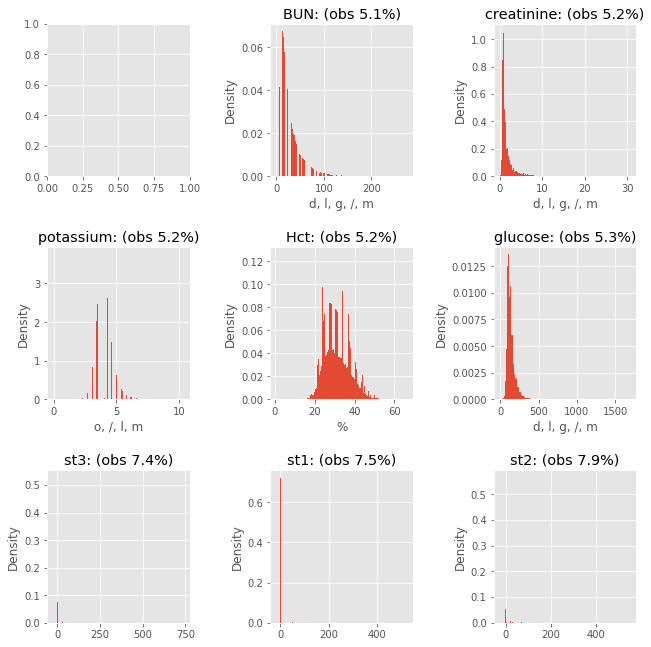

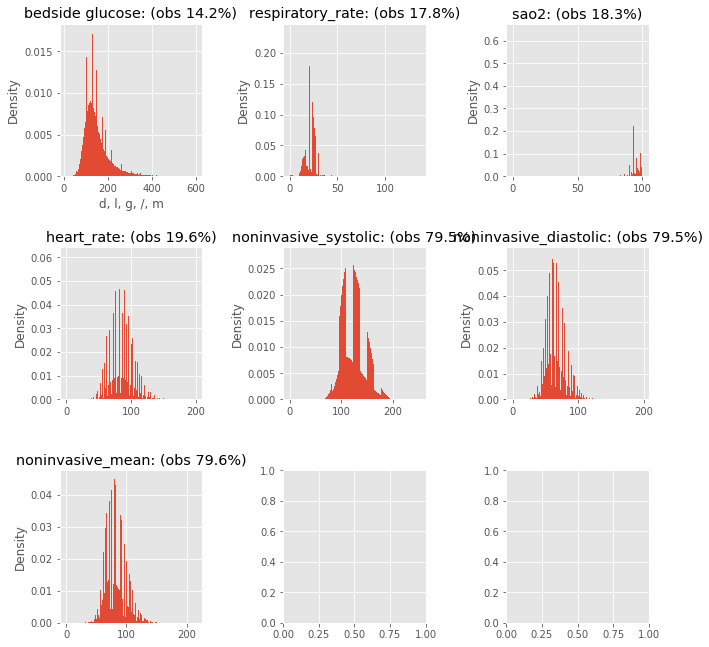

In [52]:
for i, col in enumerate(meas_rates.sort_values(ascending=True).index):
    meas_rate = meas_rates.loc[col]
        
    if i % 9 == 0:
        fig, axes = plt.subplots(3, 3, figsize=(10, 10))
        axes = list(itertools.chain.from_iterable(axes))
        fig.tight_layout(pad=5)
        
    if col[0] == 'treatment': continue
    ax = axes[i % 9]           
    
    vals = labs_vitals_treatments_df[col]
    # Simple outlier removal just for display purposes
    vals = vals[vals < vals.quantile(0.99999)]
    N = len(vals)
    
    if col[0] in counter_uoms_by_itemid.index:
        uoms = counter_uoms_by_itemid.loc[
            col[0], 'valueuom_unified'
        ].most_common(1)[0][0]
        uoms = set(u for u in uoms if u)
        uoms = ', '.join(uoms)
        if len(uoms) > 20: uoms = uoms[:17] + '...'
    else: uoms = ''
    
    ax.set_title(f"{col[0]}: (obs {meas_rate*100:.1f}%)")
    ax.hist(vals.values, bins=min(500, int(0.03 * N)), density=True)
    ax.set_xlabel(uoms)
    ax.set_ylabel('Density')
    
#     if i % 9 == 8: display(fig)

### Some Validations

In [53]:
data_df_subjects = set(data_df.index.get_level_values('subject_id'))
numerics_treatments_subjects = set(
    labs_vitals_treatments_df.index.get_level_values('subject_id')
)

assert numerics_treatments_subjects.issubset(data_df_subjects)

In [54]:
data_df_icustays = set(data_df.index.get_level_values('icustay_id'))
numerics_treatments_icustays = set(
    labs_vitals_treatments_df.index.get_level_values('icustay_id')
)

assert numerics_treatments_icustays.issubset(data_df_icustays)

In [55]:
icustays_to_subject_ids_data_df = {x[2]: x[0] for x in data_df.index}
icustays_to_subject_ids_numerics = {
    x[2]: x[0] for x in labs_vitals_treatments_df.index
}

In [56]:
for k in set(icustays_to_subject_ids_data_df.keys()).intersection(
    icustays_to_subject_ids_numerics.keys()
):
    assert icustays_to_subject_ids_data_df[k] == icustays_to_subject_ids_numerics[k]

In [57]:
l = querier.exclusion_criteria_template_vars['icustay_id'].split("','")
l = set(int(x) for x in l)

In [58]:
data_df_icustays.issubset(l)

True

In [59]:
numerics_treatments_icustays.issubset(l)

True

In [60]:
numerics_treatments_icustays.issubset(data_df_icustays)

True

In [61]:
numerics_treatments_icustays - data_df_icustays

set()

## Saving

For now, I'm going to save the `labs_vitals_treatments_df` in one hdf file on one key, along with the `data_df` in the same file on a different key. This is a bit different than `MIMIC_Extract`, which stores `labs_vitals`, `treatments`, and `data_df` (or their analog) all under separate keys.

In [62]:
# data_df.set_index([c for c in labs_vitals_treatments_df.index.names if c != 'hours_in'], inplace=True)
data_df.to_hdf(args['out_path'], key='data_df')

/crimea/conda_envs/mimic_extract/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block2_values] [items->['region', 'ethnicity', 'discharge_location', 'unit_type']]

  return pytables.to_hdf(path_or_buf, key, self, **kwargs)


In [63]:
labs_vitals_treatments_df.to_hdf(args['out_path'], key='labs_vitals_treatments')

/crimea/conda_envs/mimic_extract/lib/python3.6/site-packages/tables/attributeset.py:475: NaturalNameWarning: object name is not a valid Python identifier: 'axis0_nameAggregation Function'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/crimea/conda_envs/mimic_extract/lib/python3.6/site-packages/tables/attributeset.py:475: NaturalNameWarning: object name is not a valid Python identifier: 'block0_items_nameAggregation Function'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  check_attribute_name(name)
/crimea/conda_envs/mimic_extract/lib/python3.6/site-packages/pandas/core/generic.py:2377: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [i